# Genome scale model reconstruction of the smut fungus *Ustilago maydis*: Reproduction of simulations with CobraPy Notebook

## Introduction

This notebook is an extension to the article by Liebal et al., (2022) and reproduces the comparison of experimental growth rates with predictions by the genome scale metabolic model (GSMM) of *Ustilago maydis*. Finaly, the Memote quality check is performed. 

## Requirements
Make sure that the required files are present in the notebook directory. 

Files:
 * ../model/iCL1079.xml: SBML file, Genome scale metabolic model of *U. maydis*
 
Dependencies:
 * CPython 3.7.6
 * IPython 7.12.0
 * ipywidgets 7.5.1
 * matplotlib 3.1.3
 * numpy 1.18.1
 * pandas 1.0.1
 * cobra 0.17.1
 * memote 0.10.2

## Set-up compute environment 

In the following cell the python environment is set up. If CobraPy and Memote are not already downloaded, use the following command to download the packages them from the cell:
!{sys.executable} -m pip install cobra

In [7]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
import os
# import xlrd
import pandas as pd
# import lxml
# for export of biolog substrate test dictionary
import csv
import itertools
import operator


# Loading numpy, a library fo manipulation of numbers
import numpy as np

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

from Bio import SeqIO

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite

# from escher import Builder

# loading Memote, quality assessment of GSMM
# from memote import test_model, snapshot_report
# from FastaTools import *
from iambcodes.cobra import *
from iambcodes.fasta import *

print('System initiated.')

System initiated.


## Model loading

In [53]:
ModelFile = os.path.join('..','model', 'iUma22_Curated.xml') # iCL1079.xml 'iUma22_Curated.xml'
model=read_sbml_model(ModelFile)
model
# model.metabolites

Name,UMAY
Memory address,0x07f32e833d430
Number of metabolites,1230
Number of reactions,1859
Number of groups,0
Objective expression,1.0*BIOMASS_REACTION - 1.0*BIOMASS_REACTION_reverse_42726
Compartments,"Cytoplasm, Extracellular space, Mitochondrial Lumen, Mitochondrial Intermembrane Space"


## Support functions

In [3]:
def TestSubstrate(model, EX_Sub, Rate=10):
    '''
    Function for testing substrate consumption with exchange reaction.
    '''
    with model:
        medium = model.medium
        medium[EX_Sub] = Rate
        medium['EX_co2_e'] = 0
        medium['EX_glc__D_e'] = 0
        model.medium = medium
        return round(model.slim_optimize(),2)

def MetNewFromExist(MetIn):
    Metout = Metabolite('{}_e'.format(MetIn.id[:-2]),
                       formula = MetIn.formula,
                       name = MetIn.name,
                       compartment = 'e')
    return Metout

def CreateTransReact(MetIn):
    reaction = Reaction('Trans_{}'.format(MetIn.id),
                       name = 'Transport c<->e {}'.format(MetIn.name),
                       lower_bound = -1000,
                       upper_bound = 1000)
    MetOut = MetNewFromExist(MetIn)
    reaction.add_metabolites({MetIn:-1.0, MetOut:1.0})
    
    return reaction

def CSVexport(myDict, FName='BiologGrowthTest'):
    fields = ['id','name','id_e','id_c','growth','CL_Growth']
    with open(FName, 'w') as f:
        w = csv.DictWriter(f, fields)
        w.writeheader()
        for k in myDict:
            w.writerow({field: myDict[k].get(field) or k for field in fields})

## Data loading

Now, the external data is integrated. The excel-sheet is parsed and the GSMM file is converted to a model variable.

In [9]:
myxls = os.path.join('..','data','MSc-Lieven_Christian','sorted_growth_study.xlsx')
x1 = pd.ExcelFile(myxls)
df1 = x1.parse('Sheet1')
df1.head(3)

/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,Biolog_Name,Andere Namen,BiGG_ID,growth_experiment,In_Silico_Growth_Rate,Growth_Prediction,Boundary_Present,Status,Confusion_Marker,Unnamed: 10,Transporter/Gapfilling/renaming/pathway unclear,comments
0,29,D-Ribose,NaN,rib__D,1,0.250015,True,True,In model,1,NaN,NaN,NaN
1,76,Pyruvic Acid,NaN,pyr,1,0.086929,True,True,In model,1,NaN,NaN,NaN
2,32,D-Xylose,NaN,xyl__D,1,0.433506,True,True,In model,1,NaN,NaN,NaN


Loading the pan genome

In [48]:
myECFile = os.path.join('..','data','Sequencing','EC_Annotation.txt')
EC_dict_ori = extractEC(myECFile)
len(EC_dict_ori)

1458

In [11]:
# extracting all substrates from biolog list with BiGG metabolite identifiers
#  for source in df1['BiGG_ID'].astype(str) if source != 'nan']    
Substrate_dict = dict()
# Substrate_e = dict()
# Substrate_c = dict()
# Substrate_no = list()
for indx, Sub in enumerate(df1['BiGG_ID'].astype(str)):
    Sub_e = '{}_e'.format(Sub)
    Sub_c = '{}_c'.format(Sub)
    Sub_eIdx = np.where([Sub_e==met.id for met in model.metabolites])[0]
    Sub_cIdx = np.where([Sub_c==met.id for met in model.metabolites])[0]
    CLGrowth = str(round(df1['In_Silico_Growth_Rate'][indx],2))
    if Sub_cIdx.size>0 and Sub_eIdx.size>0:
        Substrate_dict[Sub] = {'name': model.metabolites[Sub_cIdx[0]].name, 'id_c': model.metabolites[Sub_cIdx[0]].id, 'id_e': model.metabolites[Sub_eIdx[0]].id, 'CL_Growth': CLGrowth}
    if Sub_cIdx.size>0 and Sub_eIdx.size<1:
        Substrate_dict[Sub] = {'name': model.metabolites[Sub_cIdx[0]].name, 'id_c': model.metabolites[Sub_cIdx[0]].id, 'id_e': None, 'CL_Growth': CLGrowth}
    if Sub_cIdx.size<1 and Sub_eIdx.size>0:
        Substrate_dict[Sub] = {'name': model.metabolites[Sub_eIdx[0]].name, 'id_c': None, 'id_e': model.metabolites[Sub_eIdx[0]].id, 'CL_Growth': CLGrowth}
    if Sub_cIdx.size<1 and Sub_eIdx.size<1:
        Substrate_dict[Sub] = {'name': None, 'id_c': None, 'id_e': None}


In [ ]:
#  change for loop to new substrate_dict with if loops to check which metabolic compartments exist

for Substrate in Substrate_dict.keys():
    if Substrate_dict[Substrate]['id_e'] is not None:
        EX_Sub = 'EX_{}'.format(Substrate_dict[Substrate]['id_e'])
        try: 
            model.reactions.get_by_id(EX_Sub)
        except KeyError:
            with model:
                model.add_boundary(model.metabolites.get_by_id(Substrate_dict[Substrate]['id_e']), type='exchange')
                myGrowth = TestSubstrate(model, EX_Sub)
                Substrate_dict[Substrate].update({'growth': str(myGrowth)})
#                 print('New exchange reaction for {} with growth: {}'.format(Substrate, myGrowth))        
        else:
            myGrowth = TestSubstrate(model, EX_Sub)
            Substrate_dict[Substrate].update({'growth': str(myGrowth)})
#             print('{} with growth: {}'.format(Substrate, myGrowth))
    elif Substrate_dict[Substrate]['id_c'] is not None:
        myMet = model.metabolites.get_by_id(Substrate_dict[Substrate]['id_c'])
        myTransport = CreateTransReact(myMet)
        EX_Sub = 'EX_{}_e'.format(Substrate)
        with model:
            model.add_reactions([myTransport])
            model.add_boundary(model.metabolites.get_by_id('{}_e'.format(Substrate)), type='exchange')
            myGrowth = TestSubstrate(model, EX_Sub)
            Substrate_dict[Substrate].update({'growth': str(myGrowth)})
#             print('New transport+exchange reaction for {} with growth: {}'.format(Substrate, myGrowth))        
#     else:
#         print('{} not in model.'.format(Substrate))
        
CSVexport(Substrate_dict)
print('Biolog-Model growth comparison exported.')

In [182]:
# Export of gene list with locus tags
Genes_File = os.path.join('..','data','Uma_Genes.csv')
Genes = pd.DataFrame([[x.id,i.id] for x in model.genes for i in x.reactions], nrows=400, columns=['locus-tag', 'name'])
# Genes.to_csv(Genes_File, index=False)
# model.genes.get_by_id('UMAG_00518')
# model.reactions.get_by_id('ANTPPT')

TypeError: __init__() got an unexpected keyword argument 'nrows'

In [54]:
# EC_dict[model.genes.get_by_id('UMAG_00518').name]
EC_dict = EC_dict_ori.copy()
Gene_common = [True if ModGene.name in EC_dict.keys() else False for ModGene in model.genes]
iUmaANDpan = [myGene.name for myGene in model.genes[Gene_common]]
iUmaNOTpan = [myGene.name for myGene in model.genes[list(map(operator.not_, Gene_common))]]
[EC_dict.pop(myGene.name, None) for myGene in model.genes]
panNOTiUma = list(EC_dict.keys())
f1 = os.path.join('..','data','Sequencing', 'Analysis', 'iUmaANDpan.txt')
f2 = os.path.join('..','data','Sequencing', 'Analysis','iUmaNOTpan.txt')
f3 = os.path.join('..','data','Sequencing', 'Analysis','panNOTiUma.txt')
with open(f1, "w") as f:
    f.write("\n".join(iUmaANDpan))
with open(f2, "w") as f:
    f.write("\n".join(iUmaNOTpan))
with open(f3, "w") as f:
    f.write("\n".join(panNOTiUma))
print('iUma in Pan:', sum(Gene_common))
print('iUma only:', len(model.genes)-sum(Gene_common))
print('Pan only:', len(panNOTiUma))
# model.genes.get_by_id('UMAG_00037')
# model.reactions.get_by_id('1.6.5.4-RXN')

iUma in Pan: 513
iUma only: 301
Pan only: 945


## Unique usti 521 genes

<ipython-input-289-a8968bb9d96d>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['','512 only','+1','+2','+3','all strains'])


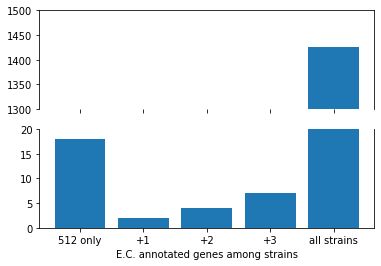

In [289]:
# loading xls with all data
myseqsXls = os.path.join('..','data','Sequencing','Pan_Uma.xlsx')
MutualFig = os.path.join('..','data','Sequencing', 'Analysis','Hist_ECGeneOverlap512.svg')


myseqs = pd.read_excel(myseqsXls, skiprows=1, index_col=None, nrows=6779, false_values=' - , -') # There are only 6779 positions with U. maydis 521 genes
myseqs.replace(' - , -', False, regex=True, inplace=True)

mylist = list(myseqs['Usti_521'])

# Finding positions in the xls that are also annotated with an ec number
IndxKeep = [mylist.index(elem) for elem in mylist for gene in EC_dict_ori if gene in elem]
IndxRmve = np.ones(len(mylist), dtype=bool)
IndxRmve[IndxKeep] = False
myseqs.drop(np.arange(len(mylist))[IndxRmve], inplace=True)

# finding the distribution of genes in other strains
GeneShare = list()
for idx, row in myseqs.iterrows():
    GeneShare.append(sum(1 for entry in row if isinstance(entry, str)))
    
    
# histogram with broken y-axis:
# https://stackoverflow.com/questions/60062664/y-xis-break-on-matplotlib-histogram

bin_edges = np.linspace(.5, 5.5, 6) # make the bins
bin_centres = np.linspace(1, 5, 5) # for plotting only
my_hist = np.histogram(GeneShare, bins = bin_edges)[0]


f, (ax, ax2) = plt.subplots(2,1,sharex = True) # make the axes
ax.bar(bin_centres, my_hist) # plot on top axes
ax2.bar(bin_centres, my_hist) # plot on bottom axes
ax.set_ylim([1300,1500]) # numbers here are specific to this example
ax2.set_ylim([0, 20]) # numbers here are specific to this example
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_bottom() 
ax.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
ax2.set_xticklabels(['','512 only','+1','+2','+3','all strains'])
plt.xlabel('E.C. annotated genes among strains')
plt.savefig(MutualFig)
plt.show()

In [286]:
# extracting the 512 unique E.C. genes and export to fasta file for KAAS analysis
ECUniqFile = os.path.join('..','data','Sequencing', 'Analysis','ECUnique512.fasta')

ECUniq = [elem.split(',')[0] for elem in myseqs.iloc[np.arange(len(GeneShare))[np.array(GeneShare)==1]]['Usti_521'].values]

myFasta = 'pangenome_AA_Uma.faa'
myDir = os.path.join('..','data','Sequencing')
myFile = os.path.join(myDir,myFasta)

records = list()
with open(myFile) as infile:
    for record in SeqIO.parse(infile, 'fasta'):
        if record.id in ECUniq:
            records.append(record)
with open(os.path.join(ECUniqFile), 'w') as outfile:
    SeqIO.write(records, outfile, "fasta")


### export of panNOTiUma list as fasta for KAAS analysis

In [ ]:
myFasta = 'pangenome_AA_Uma.faa'
myDir = os.path.join('..','data','Sequencing')
myFile = os.path.join(myDir,myFasta)

records = list()
with open(myFile) as infile:
    for record in SeqIO.parse(infile, 'fasta'):
        if record.id in panNOTiUsti:
            records.append(record)
with open(os.path.join(myDir,'panNOTiUsti.fasta'), 'w') as outfile:
    SeqIO.write(records, outfile, "fasta")

### Testing KEGG Biopython functions

In [ ]:
from Bio.KEGG import REST
result = REST.kegg_get('ko:k03800').read()
BRidx = result.find('BR:ko')
GOidx = result.find('map')
BRid = result[BRidx+5:BRidx+10]
GOid = result[GOidx+3:GOidx+8]
print(BRid, GOid)
print(result)

# finding multiple 'map' id in string of result
# https://stackoverflow.com/questions/47486563/how-can-i-get-index-of-two-of-more-duplicate-characters-in-a-string

In [ ]:
KAAStxt = 'KaasMap_panNOTiUsti.txt'
KAASpath = os.path.join('..','data','Sequencing','Analysis', KAAStxt)
myKAAS = pd.read_csv(KAASpath, delimiter='\t', names=['UMAG-ID','KO-ID'])
myKAAS
MAP_dict = dict()
for ko in myKAAS['KO-ID']:
    if str(ko) != 'nan':
        result = REST.kegg_get('ko:{}'.format(ko)).read()
        MAPidx = result.find('map')
        MAPid = result[MAPidx+3:MAPidx+8]
        if MAPid in MAP_dict:
            MAP_dict[MAPid]+=1
        else:
            MAP_dict[MAPid] = 1
MAP_dict

## Function definitions

We are testing three different growth conditions with substrates methanol, glycerol, and glucose. For each of the substrates, the corresponding exchange rate has to be activated, the approriate biomass composition formula has to be selected and exchange reactions for non-used substrates need to be closed.

## Simulation

Here, we start the simulation loop. For all substrates we use the substrate uptake rate and use the functions defined previously to update the model. The final growth rate is stored, and is then used in a plot versus the experimentally observed growth.

In [ ]:
model.reactions.query('ATP')
model.reactions.ATPS
# model.summary()

In [ ]:
# checking TCA consistency with objective to ATP hydrolysis/maintenance
with model as ATPM:
    ATPM.objective = 'ATPS'
    solution = ATPM.optimize()
    print(solution.fluxes['BIOMASS_REACTION'])
    print(model.summary())
    
# visualization    
builder = Builder()
# load U. maydis ESCHER map with Pentose phosphate pathway, Glycolysis

Escher_Central = os.path.join('Maps','umay_tcav7.json')
Escher_Glycine = os.path.join('Maps','umay_glycinev2.json')
builder = Builder(
    map_json=Escher_Central,
    model = model, # 'iCL1079.json',
)
# Run FBA with the model and add the flux data to the map
solution = builder.model.optimize()
builder.reaction_data = solution.fluxes

builder.save_html('example_map.html')

## Comparison of BIOLOG and model

### Loading substrate list

In [ ]:
model.metabolites.get_by_id('gdpfuc_c')

In [ ]:
model.metabolites.query('Glucose')
myMets = pd.DataFrame([[x.name,x.id] for x in model.metabolites])
#     print('%9s : %s' % (x.id, x.formula))
# myMets
check = 'fuc'
matching = [idx for idx,s in enumerate(myMets[1]) if check in s]
myMets.loc[matching]

In [ ]:
model_loop = model.copy()
growth_simulated = [];
for index, row in df1.iterrows():
  print(index)
  if row['Substrate'] == 'Methanol':
    model_loop = AdaptMethanol(model_loop, row['uptake rate (mmol/gCDW/h)'])
  elif row['Substrate'] == 'Glucose':
    model_loop = AdaptGlucose(model_loop, row['uptake rate (mmol/gCDW/h)'])
  elif row['Substrate'] == 'Glycerol':
    model_loop = AdaptGlycerol(model_loop, row['uptake rate (mmol/gCDW/h)'])
  else:
    print('substrate not considered')      
  model_loop.optimize()
  growth_simulated.append(model_loop.objective.value)


## Visualization

In [ ]:
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('legend', fontsize=12) 
# plt.figure(figsize=(4,3))
plt.scatter(df1['growth rate (/h)'][1:8], growth_simulated[1:8], s=100, c='k', marker='o', );
plt.scatter(df1['growth rate (/h)'][8], growth_simulated[8], s=100, c='k', marker='s');
plt.scatter(df1['growth rate (/h)'][0], growth_simulated[0], s=100, c='k', marker='x');
plt.xlabel('Experiment (/h)');
plt.ylabel('Simulation (/h)');
myline = np.linspace(0,np.max(growth_simulated),10);
plt.plot(myline,myline,'k--');
# plt.title('Growth rate comparison');
# correlation coefficient between experimental and simulated data
R2 = np.corrcoef(np.array([growth_simulated[0:9],df1['growth rate (/h)'][0:9]]))
R2Legend = r'Optimum, $R^2 = %.4f$'%(R2[0,1]) 
plt.legend([R2Legend,'Methanol (van Dijken)','Glycerol (deKoning, Moon)','Glucose (Lehnen)'], loc=2);
plt.style.use('seaborn-paper')
# plt.savefig('iOpol_growth_exp-vs-sim.png', bbox_inches='tight')
# plt.savefig('iOpol_growth_exp-vs-sim.pdf', bbox_inches='tight')

## Memote quality test

Memote performs quality assessments of genome scale metabolic models. The process can take a while, around 5 min.

In [ ]:
mem_return, mem_result = test_model(model, results=True)
with open('iUmay_MemoteReport.html', 'w') as f:
    f.write(snapshot_report(mem_result))



## correcting reactions and metabolites for balance

In [ ]:
# A-3-OXO-ACID_c is unbalanced
DelRct = ['3-OXOACID-COA-TRANSFERASE-RXN']
model.remove_reactions(DelRct, remove_orphans=True)

In [4]:
model.optimize()
print(model.summary())
[reaction.flux for reaction in model.reactions.query('TRNA')]
# print(model.metabolites.get_by_id('fum[c]').summary())

Objective
1.0 BIOMASS_REACTION = 0.4939843816958042

Uptake
------
Metabolite    Reaction    Flux  C-Number C-Flux
     co2_e    EX_co2_e   2.959         1  4.70%
  glc__D_e EX_glc__D_e      10         6 95.30%
     nh4_e    EX_nh4_e   2.717         0  0.00%
      o2_e     EX_o2_e   3.174         0  0.00%
      pi_e     EX_pi_e  0.4887         0  0.00%
     so4_e    EX_so4_e 0.04051         0  0.00%

Secretion
---------
Metabolite    Reaction    Flux  C-Number C-Flux
     fum_e    EX_fum_e -0.2366         4  2.31%
     h2o_e    EX_h2o_e  -13.58         0  0.00%
  mal__L_e EX_mal__L_e  -10.02         4 97.69%



[0.0]

In [ ]:
any(['3-OXO-ACID' in mylst.id for mylst in lowMet])
# lowMet[0]


### Dependencies and versions
The code below was used to identify the versions of dependent packages.

In [ ]:
%load_ext watermark
%watermark -v -m -p ipywidgets,matplotlib,numpy,pandas,cobra,memote,watermark

## model changes start

In [19]:
# maltose is used as substrate according to biolog
# adding maltase reactions
model.reactions.get_by_id('RXN-14350').id = 'Maltase'
model.reactions.get_by_id('Maltase').build_reaction_from_string('h2o_c + malt_c --> 2 glc__D_c')
# maltose is preferentially metabolized by an unusual polymerization and depolymerization stept via Amalt1
model.reactions.get_by_id('AMALT1').bounds = 0,0


In [23]:
write_sbml_model(model, 'iUma22_BiologCorr_Maltase.xml')

## model changes stop

In [28]:
TrackMet = 'malt_c' # malt_c
medium = model.medium
medium['EX_glc__D_e'] = 0 
medium['EX_malt_e'] = 10
model.medium = medium
solution = model.optimize()
[print('{}: {} ({})'.format(rct.id,solution[rct.id], rct.reaction)) for rct in model.metabolites.get_by_id(TrackMet).reactions if abs(solution[rct.id])>0]

Maltase: 10.0 (h2o_c + malt_c --> 2.0 glc__D_c)
Trans_malt_c: -10.0 (malt_c <=> malt_e)


[None, None]

In [32]:
model.metabolites.get_by_id('Lfmkynr_c').charge = 2.